# RL Training and Comparison against optimal Hedges using Black-Scholes
---
<p>
In this notebook we will train a reinforcement learning model 
<b>Proximal Policy Optimization (PPO)</b> to dynamically hedge the option at each step 
based on the provided observation space consisting of:
</p>
<ul>
<li>normalized price</li>
<li>time to maturity</li>
<li>current hedge</li>
</ul>

We will then use calculate the delta change and out hedge and finally compare 
it to the optimal hedges calculated using BSM

In [76]:
import gymnasium as gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
import sys
import importlib
sys.path.append('../utils')
from bsm import bs_call_price, bs_delta
from env import HedgingEnv

In [77]:
def make_env(reward_type="hedge_error"):
    def _init():
        env = HedgingEnv(reward_type=reward_type)
        env = Monitor(env)
        return env
    return _init

env = DummyVecEnv([make_env(reward_type="hedge_error")])

In [78]:
model = PPO(
    "MlpPolicy", # Multi-layer perceptron (feedforward)
    env,
    learning_rate=3e-4,
    n_steps=2048, # steps before policy update
    batch_size=64,
    gamma=0.99, # 0: immedeate reward or greedy 1: Long term
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.005,
    verbose=1
)

Using cpu device


In [79]:
model.learn(total_timesteps=1_000_000)
model.save("ppo_hedging_model")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 251      |
|    ep_rew_mean     | -518     |
| time/              |          |
|    fps             | 5327     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 251         |
|    ep_rew_mean          | -450        |
| time/                   |             |
|    fps                  | 3842        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009572015 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.00821     |
|    learning_rate        | 0.

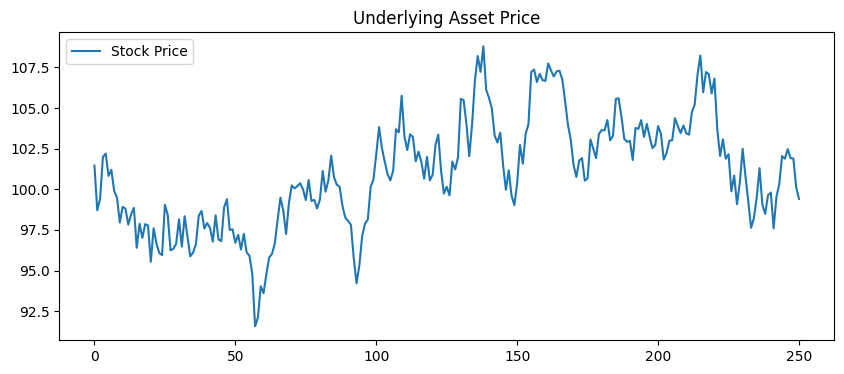

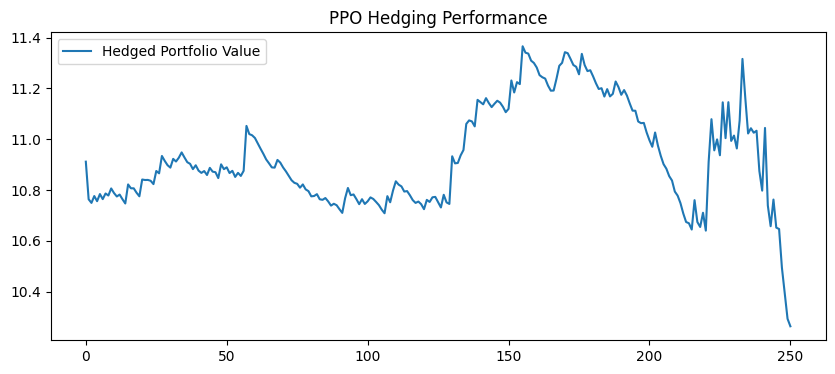

Total Reward: -119.976


In [83]:
env_test, _ = HedgingEnv(reward_type='hedge_error'), None
obs, info = env_test.reset()
done = False

prices, hedges, portfolio_vals, rewards = [], [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env_test.step(action)
    rewards.append(reward)
    prices.append(env_test.S[env_test.t])
    hedges.append(env_test.hedge)
    portfolio_vals.append(env_test.portfolio_value)

plt.figure(figsize=(10,4))
plt.plot(prices, label='Stock Price')
plt.legend()
plt.title('Underlying Asset Price')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(portfolio_vals, label='Hedged Portfolio Value')
plt.legend()
plt.title('PPO Hedging Performance')
plt.show()

print(f"Total Reward: {np.sum(rewards):.3f}")

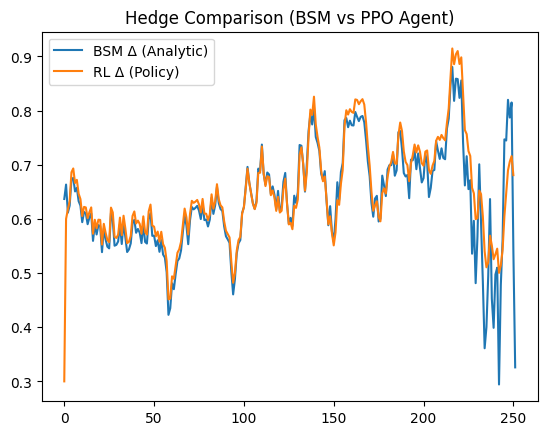

[np.float64(0.6368306511756191), np.float64(0.66343147350725), np.float64(0.6115656053217764), np.float64(0.6246183217155912), np.float64(0.6723606998675276), np.float64(0.6758475674451033), np.float64(0.6507168070198772), np.float64(0.6574470614816423), np.float64(0.6327298500822667), np.float64(0.6245802344933898), np.float64(0.5940133882312093)]
[np.float64(0.3), np.float64(0.6), np.float64(0.6175623133778572), np.float64(0.6326882332563399), np.float64(0.686080478131771), np.float64(0.6931797802448272), np.float64(0.6663544848561286), np.float64(0.6721651285886764), np.float64(0.646543501317501), np.float64(0.6365882456302643), np.float64(0.6053073540329933)]


In [84]:
deltas_bsm = [bs_delta(S, env_test.K, env_test.mu, env_test.sigma, env_test.T - i*env_test.dt)
              for i, S in enumerate(env_test.S)]
plt.plot(deltas_bsm, label="BSM Δ (Analytic)")
plt.plot(hedges, label="RL Δ (Policy)")
plt.legend()
plt.title("Hedge Comparison (BSM vs PPO Agent)")
plt.show()
print(deltas_bsm[:11])
print(hedges[:11])

In [85]:
def eval_policy(policy=None, episodes=20, reward_type="hedge_error"):
    total_rewards = []
    for ep in range(episodes):
        env = HedgingEnv(reward_type=reward_type)
        obs, info = env.reset()
        done = False
        ep_reward = 0.0

        while not done:
            if policy is None:
                action = env.action_space.sample()
            else:
                action, _ = policy.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)
            ep_reward += reward
        total_rewards.append(ep_reward)
    return np.mean(total_rewards), np.std(total_rewards)

# Evaluate a random policy (baseline)
random_mean, random_std = eval_policy(policy=None)
print(f"Random policy: {random_mean:.2f} ± {random_std:.2f}")

# Evaluate the trained PPO model
ppo_mean, ppo_std = eval_policy(policy=model)
print(f"PPO-trained policy: {ppo_mean:.2f} ± {ppo_std:.2f}")

Random policy: -446.00 ± 218.87
PPO-trained policy: -105.65 ± 7.27


### Summary

As we can see the PPO agent was trained to dynamically hedge European call options and significantly outperformed a random baseline (PPO: -105.65 ± 7.27 vs Random: -446.00 ± 218.87, ≈76% improvement). The RL hedges closely track BSM deltas and produce a stable hedged portfolio. 

Next steps: add transaction costs, test other option types, and stress-test market regimes.
